
# Previsão de `IPG2211A2N` a partir de `DATE`

Este notebook utiliza o dataset `Electric_Production.csv` (colunas padrão do FRED: `DATE`, `IPG2211A2N`).  
Objetivos:
- **Evitar data leakage** via separação temporal estrita (treino / validação / teste).
- **Treinar e avaliar** um modelo de previsão de série temporal.

> Observação: ajuste o caminho do dataset em `DATA_PATH` se necessário.  
> Dataset padrão esperado aqui: `/mnt/data/Electric_Production.csv`.

Divisão sugerida:
- **Treino**: todo o histórico exceto os últimos 48 meses
- **Validação**: penúltimos 24 meses (para ajuste/early stopping)
- **Teste**: últimos 24 meses (avaliação final)


---

# Modelo 1 — LSTM (Keras/TensorFlow)

## Estratégia de Split (sem vazamento de dados)

- A divisão é **temporal**: treino → validação → teste (nesse ordem).
- Transformações como **padronização/normalização** são **ajustadas apenas no conjunto de treino** e aplicadas a val/test.
- Para janelas (LSTM), as sequências de validação/teste **usam apenas contexto passado** (incluindo o final do treino), nunca valores futuros do período avaliado.


Tamanhos: 317 40 40


,ds,y
314,2011-03-01,99.1028
315,2011-04-01,89.3583
316,2011-05-01,90.0698


,ds,y
317,2011-06-01,102.8204
318,2011-07-01,114.7068
319,2011-08-01,113.5958


,ds,y
357,2014-10-01,92.3837
358,2014-11-01,99.7033
359,2014-12-01,109.3477


Shapes -> X_train: (305, 12, 1) X_val: (40, 12, 1) X_test: (40, 12, 1)


/Users/pedromoritabannwart/Code/inteli/LSTM/Ponderada-LSTM-SEMANA9/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Menor val_loss: 0.04153670370578766
TESTE -> RMSE: 4.2970 | MAE: 3.2361 | MAPE: 3.06%


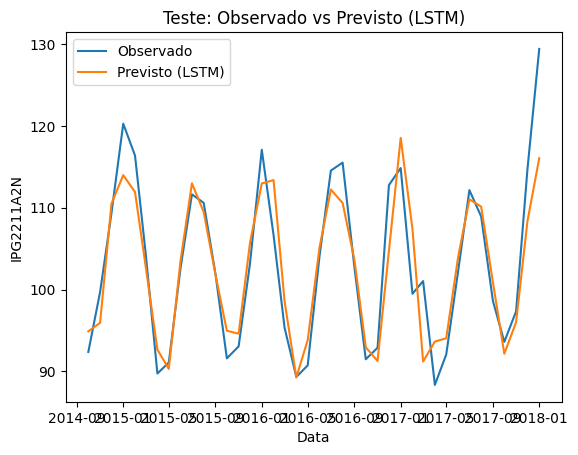

,ds,y,yhat
35,2017-09-01,98.6154,100.879234
36,2017-10-01,93.6137,92.163773
37,2017-11-01,97.3359,96.014847
38,2017-12-01,114.7212,108.365913
39,2018-01-01,129.4048,116.051277


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ---------- Configurações ----------
np.random.seed(42)
DATA_PATH = "Electric_Production.csv"  # ajuste se necessário
WINDOW = 12           # janela de 12 meses (use >= ao menos um ciclo sazonal, se houver)
EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 20

# ---------- Carregar e preparar dados ----------
df_raw = pd.read_csv(DATA_PATH)
if "DATE" not in df_raw.columns or "IPG2211A2N" not in df_raw.columns:
    raise ValueError("O CSV deve conter as colunas 'DATE' e 'IPG2211A2N'.")

df_raw["DATE"] = pd.to_datetime(df_raw["DATE"])
df_raw = df_raw.sort_values("DATE").reset_index(drop=True)

# Frequência mensal contínua; interpolar se houver faltas
ts = (df_raw.set_index("DATE")[["IPG2211A2N"]]
              .asfreq("MS"))
if ts["IPG2211A2N"].isna().any():
    ts["IPG2211A2N"] = ts["IPG2211A2N"].interpolate(limit_direction="both")

df = ts.reset_index().rename(columns={"DATE":"ds", "IPG2211A2N":"y"})

# ---------- Split temporal 80/10/10 sem shuffle ----------
df = df.sort_values("ds").reset_index(drop=True)

TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9

# 1) train vs temp (val+test)
df_train, df_temp = train_test_split(
    df, test_size=VAL_RATIO + TEST_RATIO, shuffle=False
)
# 2) temp -> val vs test (mantendo ordem)
rel_test = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
df_val, df_test = train_test_split(
    df_temp, test_size=rel_test, shuffle=False
)

train, val, test = df_train.copy(), df_val.copy(), df_test.copy()

print("Tamanhos:", len(train), len(val), len(test))
display(train.tail(3)); display(val.head(3)); display(test.head(3))

# ---------- Escalonamento SEM vazamento (fit só no treino) ----------
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(train[["y"]].values)
y_val_scaled   = scaler.transform(val[["y"]].values)
y_test_scaled  = scaler.transform(test[["y"]].values)

# ---------- Construção de janelas com contexto correto ----------
# Estratégia:
# - Para treino/validação: criamos janelas em (train + val) e rotulamos por índice.
#   Máscaras separam rótulos de treino e de validação.
# - Para teste: criamos janelas em (train + val + test) e selecionamos rótulos no intervalo de teste.
# Assim, as janelas de val e test podem usar histórico anterior (contexto passado), sem ver o futuro.

def build_windows(arr, window):
    X, y = [], []
    for i in range(window, len(arr)):
        X.append(arr[i-window:i])
        y.append(arr[i])
    X = np.array(X)
    y = np.array(y)
    # adicionar dimensão de features (=1)
    return X.reshape((X.shape[0], X.shape[1], 1)), y

len_train = len(y_train_scaled)
len_val   = len(y_val_scaled)
len_test  = len(y_test_scaled)

# Treino + Validação
train_val_scaled = np.concatenate([y_train_scaled, y_val_scaled], axis=0)
X_tv, y_tv = build_windows(train_val_scaled, WINDOW)
# Índice do rótulo (na série "train_val_scaled") para cada linha de y_tv
label_indices_tv = np.arange(WINDOW, WINDOW + len(y_tv))

# Limites de rótulos de treino e validação dentro de train_val_scaled
train_last_label_index = len_train - 1
val_last_label_index   = len_train + len_val - 1

train_mask = label_indices_tv <= train_last_label_index
val_mask   = (label_indices_tv > train_last_label_index) & (label_indices_tv <= val_last_label_index)

X_train, y_train = X_tv[train_mask], y_tv[train_mask]
X_val,   y_val   = X_tv[val_mask],   y_tv[val_mask]

# Teste (usa histórico de train+val como contexto)
full_scaled = np.concatenate([y_train_scaled, y_val_scaled, y_test_scaled], axis=0)
X_full, y_full = build_windows(full_scaled, WINDOW)
label_indices_full = np.arange(WINDOW, WINDOW + len(y_full))
test_start_label_index = len_train + len_val  # primeiro rótulo no bloco de teste
test_mask = label_indices_full >= test_start_label_index

X_test, y_test_arr = X_full[test_mask], y_full[test_mask]

print("Shapes ->", "X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

# Sanidade: número de labels de teste deve ser igual ao tamanho do conjunto de teste
assert X_test.shape[0] == len(test), "Número de previsões de teste ≠ tamanho do conjunto de teste."

# ---------- Modelo LSTM ----------
model = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[es]
)

print("Menor val_loss:", float(np.min(hist.history["val_loss"])))

# ---------- Previsão no TESTE e inversão do scaling ----------
yhat_test_scaled = model.predict(X_test, verbose=0)
yhat_test = scaler.inverse_transform(yhat_test_scaled)

# Alinhar datas: como garantimos contexto, há uma previsão por ponto em 'test'
pred = pd.DataFrame({"ds": test["ds"].values, "yhat": yhat_test.ravel()})
eval_df = test.copy().reset_index(drop=True).merge(pred, on="ds", how="left")

# ---------- Métricas ----------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

rmse = np.sqrt(mean_squared_error(eval_df["y"], eval_df["yhat"]))
mae  = mean_absolute_error(eval_df["y"], eval_df["yhat"])
mape_val = mape(eval_df["y"], eval_df["yhat"])

print(f"TESTE -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape_val:.2f}%")

# ---------- Plot ----------
plt.figure()
plt.plot(eval_df["ds"], eval_df["y"], label="Observado")
plt.plot(eval_df["ds"], eval_df["yhat"], label="Previsto (LSTM)")
plt.title("Teste: Observado vs Previsto (LSTM)")
plt.xlabel("Data"); plt.ylabel("IPG2211A2N")
plt.legend()
plt.show()

# Últimas linhas para inspeção
eval_df.tail()



## Métricas
- **RMSE**
- **MAE**
- **MAPE** (ignora valores 0)


## Gráfico
O gráfico compara **observado vs. previsto** no período de teste.
